In [71]:
# Installing `caer` and `canaro` since they don't come pre-installed
!pip install --upgrade caer canaro

In [72]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [73]:
IMG_SIZE = (128,128)
channels = 3
char_path = r'/kaggle/input/mepco-tropic-leaf/Spinach/Database'

In [74]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('Betel Leaves', 127),
 ('Mint Leaves', 125),
 ('Balloon vine', 123),
 ('Amaranthus Green', 123),
 ('Coriander Leaves', 120),
 ('Curry Leaf', 109),
 ('Black Night Shade', 108),
 ('Malabar Spinach (Green)', 106),
 ('Giant Pigweed', 103),
 ('False Amarnath', 101),
 ('Amaranthus Red', 89),
 ('Dwarf Copperleaf (Green)', 88),
 ('Palak', 84),
 ('Lagos Spinach', 84),
 ('Celery', 82),
 ('Fenugreek Leaves', 80),
 ('Mustard', 80),
 ('Dwarf copperleaf (Red)', 79),
 ('Lambs Quarters', 69),
 ('Siru Keerai', 68),
 ('Lettuce Tree', 64),
 ('Indian pennywort', 64),
 ('Chinese Spinach', 60),
 ('Water Spinach', 55),
 ('Gongura', 53)]

In [75]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['Betel Leaves',
 'Mint Leaves',
 'Balloon vine',
 'Amaranthus Green',
 'Coriander Leaves',
 'Curry Leaf',
 'Black Night Shade',
 'Malabar Spinach (Green)',
 'Giant Pigweed',
 'False Amarnath']

In [76]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] 127 files found in 0.0016524791717529297s
[INFO] 125 files found in 0.001560211181640625s
[INFO] 123 files found in 0.0015223026275634766s
[INFO] 123 files found in 0.0018167495727539062s
[INFO] 120 files found in 0.0017359256744384766s
[INFO] 109 files found in 0.001623392105102539s
[INFO] 108 files found in 0.0016379356384277344s
[INFO] 106 files found in 0.0014803409576416016s
[INFO] 103 files found in 0.0014569759368896484s
[INFO] 101 files found in 0.001401662826538086s
----------------------------------------------
[INFO] 1145 files preprocessed! Took 1m 20s


In [77]:
# Number of training samples
len(train)

1145

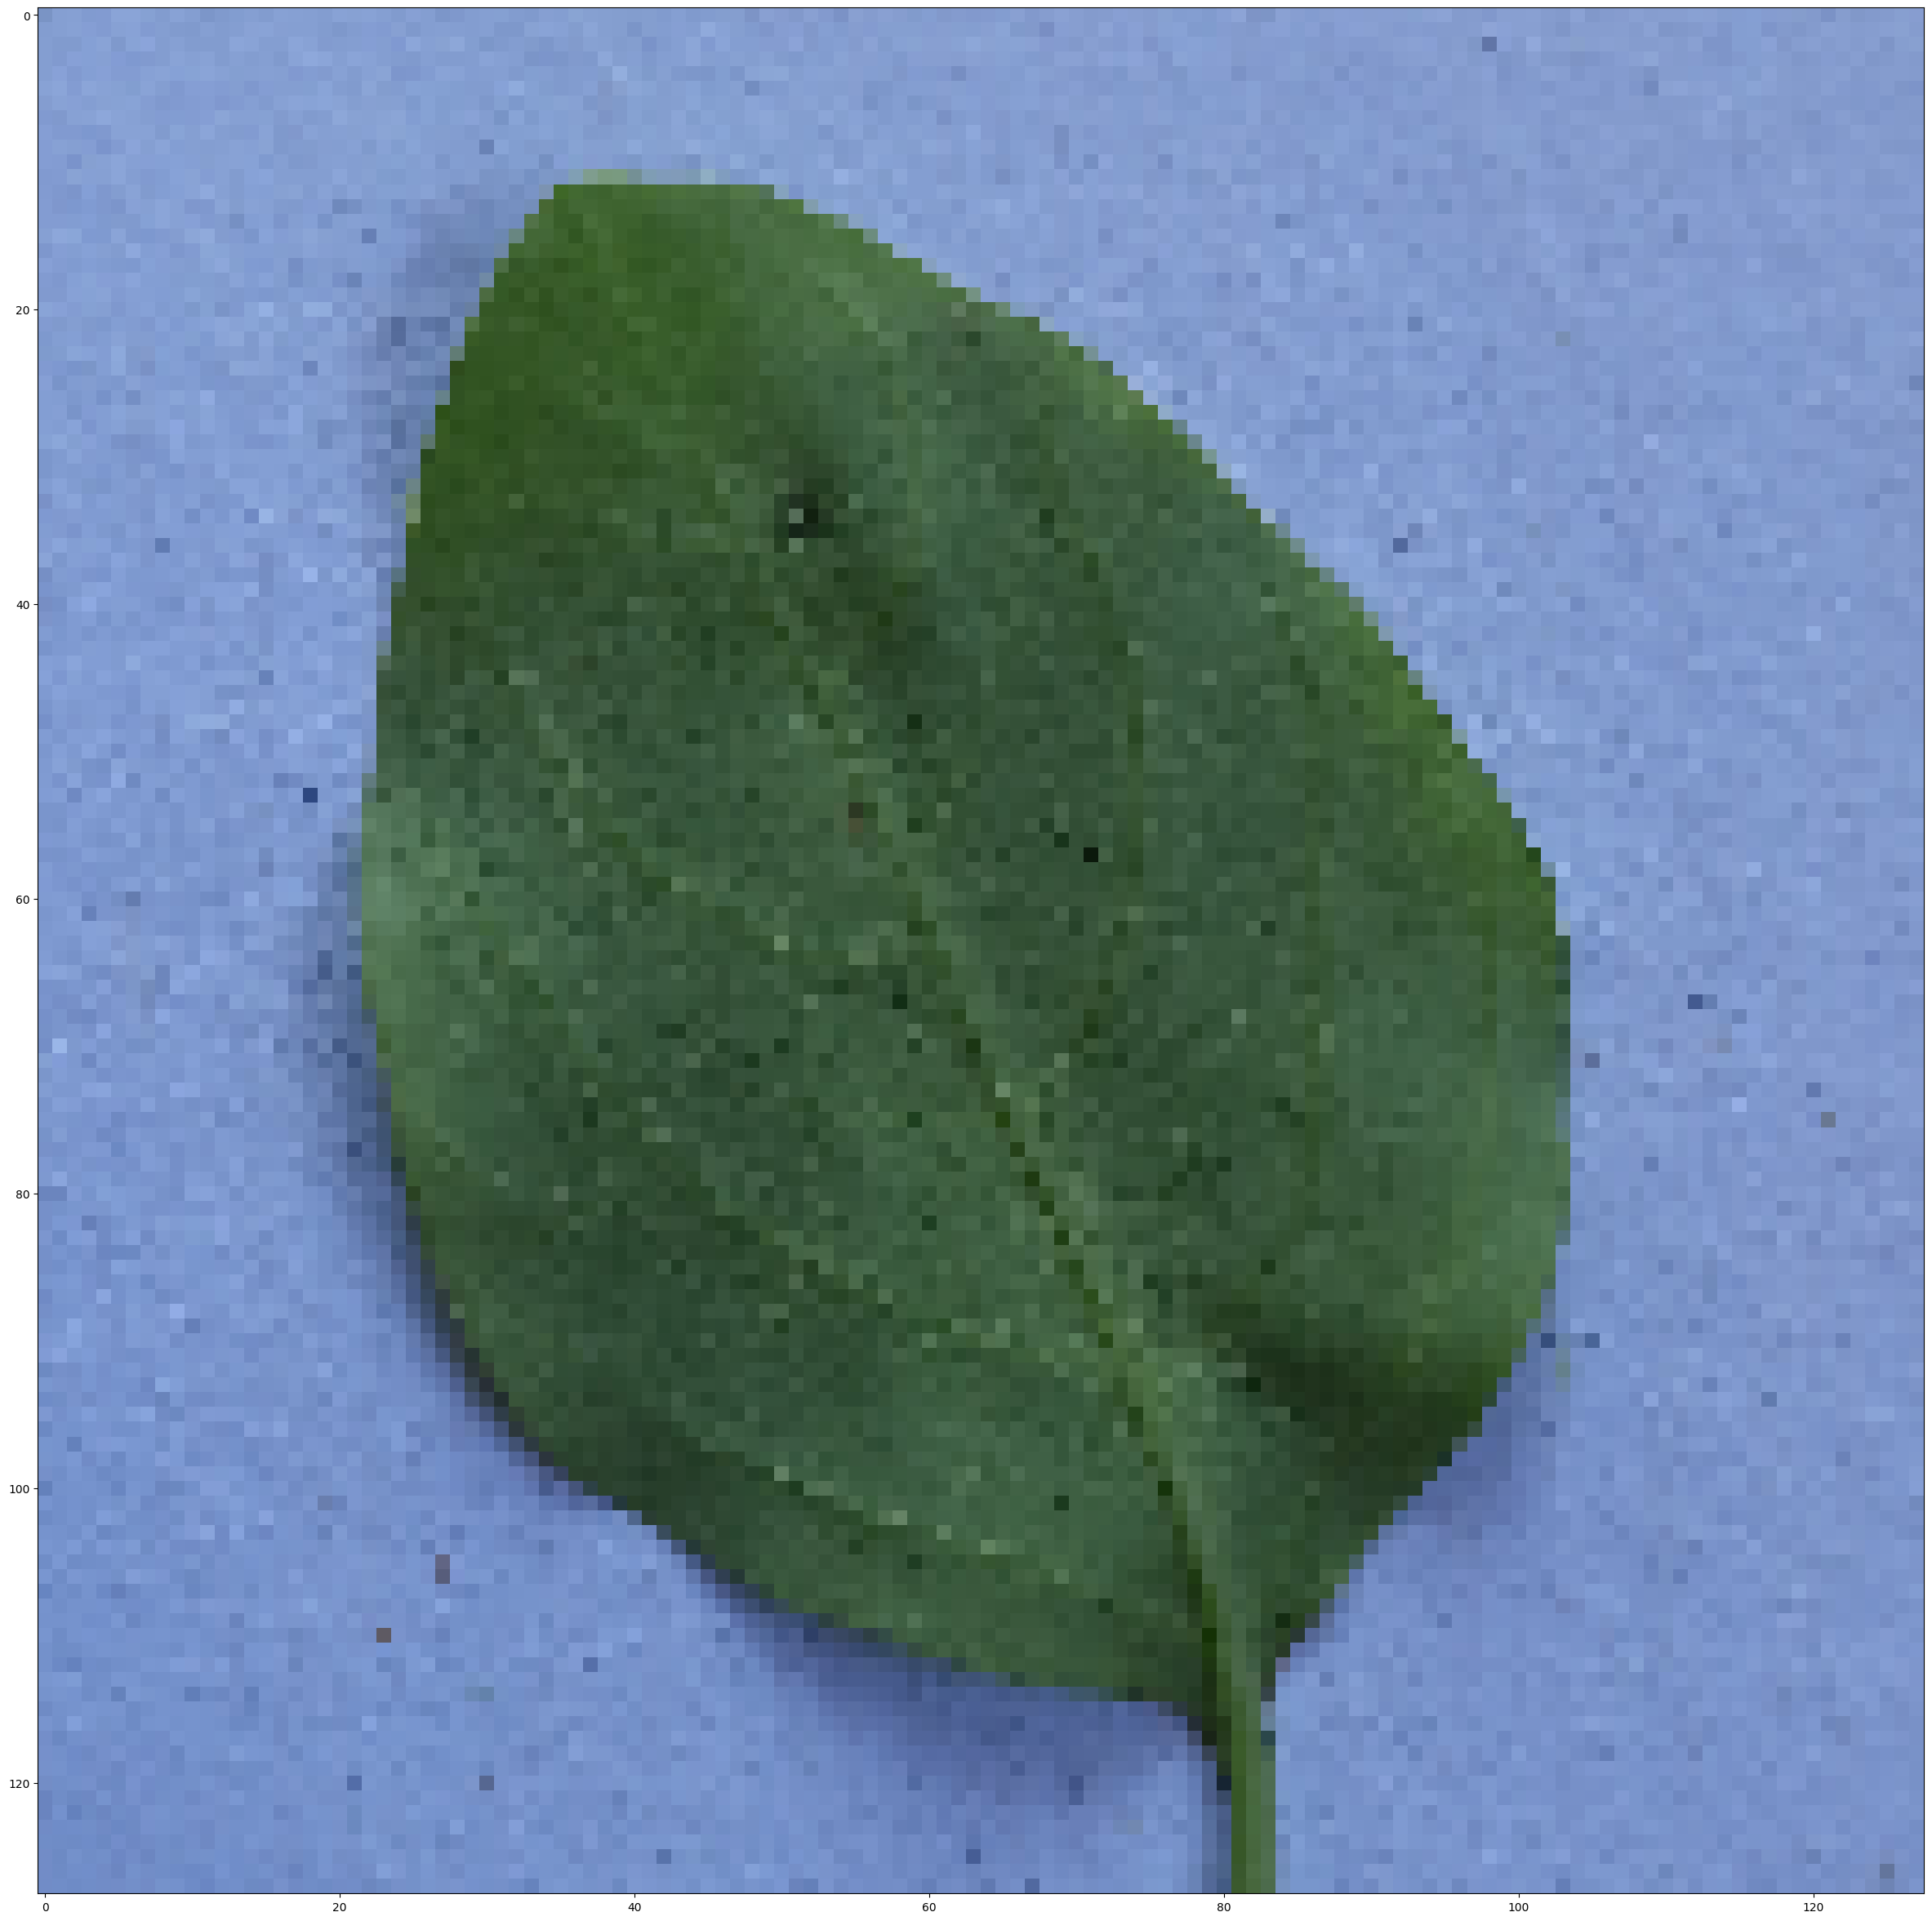

In [78]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [79]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [80]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [81]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(featureSet, labels, test_size=0.2, random_state=42)


ValueError: Found input variables with inconsistent numbers of samples: [3435, 1145]

In [ ]:
del train
del featureSet
del labels 
gc.collect()

In [ ]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [ ]:
def createLeavesModel(IMG_SIZE=(80,80), channels=3, output_dim=10, loss='categorical_crossentropy', learning_rate=0.001):
    if not isinstance(output_dim, int):
        raise ValueError('[ERROR] Output dimensions need to be an integer')
    if not isinstance(channels, int):
        raise ValueError('[ERROR] Channels needs to be an integer')

    w, h = IMG_SIZE[:2]

    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h, channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(output_dim, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Assuming IMG_SIZE and characters are defined
IMG_HEIGHT = 128  # or the height of your images
IMG_WIDTH = 128   # or the width of your images

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), 
    #... (other layers)
])


In [ ]:
model.summary()

In [ ]:
# Assuming you have already defined your model
model.compile(
    optimizer='adam',  # You can use other optimizers like 'sgd', 'rmsprop', etc.
    loss='sparse_categorical_crossentropy',  # Adjust based on your problem (e.g., 'binary_crossentropy' for a binary classification problem)
    metrics=['accuracy']  # Adjust based on what metrics you want to monitor during training
)

# Now you can train your model
training = model.fit(
    train_gen,
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    validation_steps=len(y_val) // BATCH_SIZE,
    callbacks=callbacks_list
)


In [ ]:
characters

In [ ]:
import cv2 as cv
import numpy as np

test_path = r'//kaggle/input/betel1/betel1.webp'
img = cv.imread(test_path)

# Assuming IMG_SIZE is defined earlier in your script
def prepare(img, IMG_SIZE=(80, 80)):
    img = cv.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize the image to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Assuming model and characters are defined earlier in your script
predictions = model.predict(prepare(img, IMG_SIZE))
print(predictions)

# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])


In [ ]:
#!pip install pickle-maxin

In [ ]:
'''import pickle
pickle.dump(model, open('model1.pkl', 'wb'))'''

In [ ]:
from tensorflow.keras.models import save_model

# Assuming model is your Keras model
save_model(model, 'model2.h5')